<a href="https://colab.research.google.com/github/KianLian-Soc/IUST_Study/blob/main/hw1_covtype_ok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title GPU Checking
import torch, platform, sys, os, numpy as np
print("Python:", sys.version.split()[0], "| PyTorch:", torch.__version__, "| OS:", platform.platform())
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Python: 3.12.12 | PyTorch: 2.8.0+cu126 | OS: Linux-6.6.105+-x86_64-with-glibc2.35
CUDA available: True
GPU: Tesla T4


In [ ]:
#@ Imorts& Gpu Couda handeling error
import os, time, pickle
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#  Reapidability
torch.manual_seed(50)
np.random.seed(50)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin = True if device.type == 'cuda' else False
print("Device:", device,"\nCuda status is",pin)

Device: cuda 
Cuda status is True



  #@title   2048 | 4096| 8192

In [ ]:
#@title Hyperparamer init.
EPOCHS = 20               #@param {type:"integer"}
BATCH_SIZE = 4096         #@param {type:"integer"}
BASE_LR = 0.001           #@param {type:"number"}
MAX_LR  = 0.005           #@param {type:"number"}
WEIGHT_DECAY = 1e-4       #@param {type:"number"}
LABEL_SMOOTH = 0.05       #@param {type:"number"}
PATIENCE = 5              #@param {type:"integer"}
USE_AMP = False            #@param {type:"boolean"}
NUM_WORKERS = 2           #@param {type:"integer"}

print(f"EPOCHS={EPOCHS}, BATCH_SIZE={BATCH_SIZE}, MAX_LR={MAX_LR}, AMP={USE_AMP}")


EPOCHS=20, BATCH_SIZE=4096, MAX_LR=0.005, AMP=False


In [ ]:
#@title Laoding the Covertype Datatset
cov = fetch_covtype()
X = cov.data.astype(np.float32)
y = cov.target.astype(np.int64) - 1  # 1..7 -> 0..6 Pytorch Sync.

n_features = X.shape[1]
n_classes = len(np.unique(y))
print("X shape:", X.shape, "| classes:", n_classes)

X shape: (581012, 54) | classes: 7


In [ ]:
#@title  Train/Test Scaling to (0,1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = MinMaxScaler(feature_range=(0.0, 1.0))
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (464809, 54)  Test: (116203, 54)


In [ ]:
#@title Building the DataLoaders
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_ds  = TensorDataset(torch.from_numpy(X_test),  torch.from_numpy(y_test))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=pin, persistent_workers=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=pin, persistent_workers=False)
len(train_loader), len(test_loader)

(114, 29)

In [ ]:
#@title MLP Definition
class MLP(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 488),
            nn.BatchNorm1d(488),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),

            nn.Linear(488, 488),
            nn.BatchNorm1d(488),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            nn.Linear(488, 128),        #Compresion
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),

            nn.Linear(128, num_classes),
        )
    def forward(self, x):
        return self.net(x)

model = MLP(n_features, n_classes).to(device)
print(model)


MLP(
  (net): Sequential(
    (0): Linear(in_features=54, out_features=488, bias=True)
    (1): BatchNorm1d(488, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=488, out_features=488, bias=True)
    (5): BatchNorm1d(488, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=488, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=128, out_features=7, bias=True)
  )
)


In [ ]:
#@title eval with Loss And Acc + Param Counting
def evaluate_with_loss(net, loader, criterion):
    net.eval()
    preds, gts = [], []
    total_loss = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = net(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)
            pred = logits.argmax(1)
            preds.append(pred.cpu().numpy())
            gts.append(yb.cpu().numpy())
    y_true = np.concatenate(gts)
    y_pred = np.concatenate(preds)
    acc = accuracy_score(y_true, y_pred)
    avg_loss = total_loss / len(loader.dataset)
    return acc, avg_loss

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print("Trainable params:", f"{count_params(model):,}")


Trainable params: 331,175


In [ ]:
#@title Criterion/Optimizer/Scheduler with Gemini help I added to my code
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
optimizer = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=MAX_LR, epochs=EPOCHS, steps_per_epoch=len(train_loader)
)

#scaler = torch.cuda.amp.GradScaler(enabled=(USE_AMP and device.type=='cuda'))
scaler = torch.amp.GradScaler('cuda')

# لاگ‌ها
train_loss_hist, train_acc_hist = [], []
test_loss_hist,  test_acc_hist  = [], []
epoch_time_sec = []

best_acc, best_epoch, best_state = 0.0, 0, None

In [ ]:
#@title Training + Eval per each epoch + Early Stopping
for ep in range(1, EPOCHS + 1):
    t0 = time.time()
    model.train()
    running_loss = 0.0
    #print(scaler.is_enabled)
    #scaler = torch.cuda.amp.GradScaler()

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        if scaler.is_enabled():
            with torch.amp.autocast('cuda'):
                logits = model(xb)
                loss = criterion(logits, yb)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        scheduler.step()
        running_loss += loss.item() * xb.size(0)

    # Avg Loss on train
    train_loss = running_loss / len(train_loader.dataset)

    # Eval train/test
    train_acc, _      = evaluate_with_loss(model, train_loader, criterion)
    test_acc, test_ls = evaluate_with_loss(model, test_loader,  criterion)

    # Logging the data
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    test_loss_hist.append(test_ls)
    test_acc_hist.append(test_acc)

    # Time of each epoch
    ep_secs = time.time() - t0
    epoch_time_sec.append(ep_secs)

    print(f"Epoch {ep:02d}/{EPOCHS} | "
          f"TrainLoss: {train_loss:.4f} | TrainAcc: {train_acc*100:.2f}% | "
          f"TestLoss: {test_ls:.4f} | TestAcc: {test_acc*100:.2f}% | "
          f"Time: {ep_secs:.1f}s")

    # Early stopping on TestAcc
    if test_acc > best_acc:
        best_acc = test_acc
        best_epoch = ep
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        patience_cnt = 0
    else:
        patience_cnt += 1
        if patience_cnt >= PATIENCE:
            print("Early stopping.")
            break

#Loading the best State
if best_state is not None:
    model.load_state_dict(best_state)

print(f"\nBest Test Accuracy: {best_acc*100:.2f}% @ epoch {best_epoch}")

Epoch 01/20 | TrainLoss: 1.0979 | TrainAcc: 74.00% | TestLoss: 0.7934 | TestAcc: 73.92% | Time: 11.8s
Epoch 02/20 | TrainLoss: 0.7639 | TrainAcc: 78.19% | TestLoss: 0.7029 | TestAcc: 78.24% | Time: 11.1s
Epoch 03/20 | TrainLoss: 0.6979 | TrainAcc: 81.26% | TestLoss: 0.6451 | TestAcc: 81.16% | Time: 11.2s
Epoch 04/20 | TrainLoss: 0.6502 | TrainAcc: 83.36% | TestLoss: 0.6069 | TestAcc: 83.19% | Time: 11.2s
Epoch 05/20 | TrainLoss: 0.6153 | TrainAcc: 85.18% | TestLoss: 0.5799 | TestAcc: 85.02% | Time: 11.1s
Epoch 06/20 | TrainLoss: 0.5873 | TrainAcc: 86.51% | TestLoss: 0.5511 | TestAcc: 86.16% | Time: 11.1s
Epoch 07/20 | TrainLoss: 0.5621 | TrainAcc: 87.65% | TestLoss: 0.5320 | TestAcc: 87.30% | Time: 10.3s
Epoch 08/20 | TrainLoss: 0.5436 | TrainAcc: 88.97% | TestLoss: 0.5038 | TestAcc: 88.62% | Time: 10.9s
Epoch 09/20 | TrainLoss: 0.5270 | TrainAcc: 89.97% | TestLoss: 0.4862 | TestAcc: 89.53% | Time: 11.1s
Epoch 10/20 | TrainLoss: 0.5133 | TrainAcc: 90.35% | TestLoss: 0.4776 | TestAcc: 8

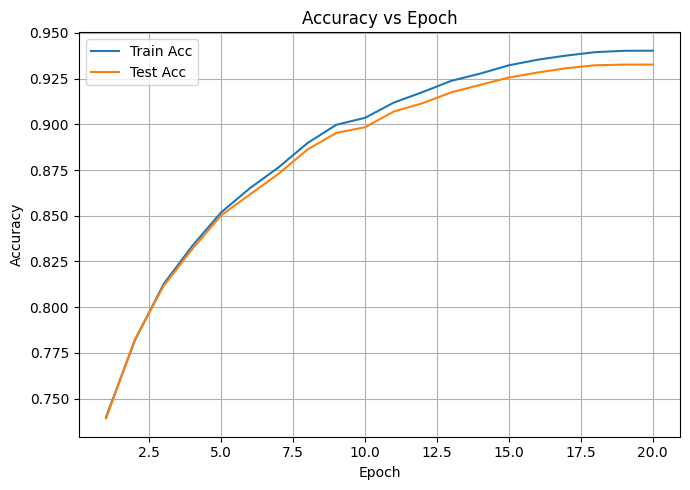

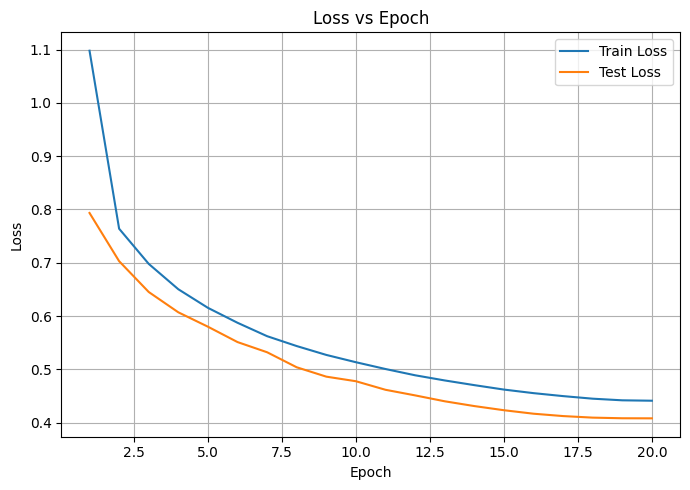

Saved: Results/acc_curve.png, Results/loss_curve.png, Results/training_log.csv


In [ ]:
#@title Plot+ Save in CSV file(optional)
os.makedirs("Results", exist_ok=True)

epochs_range = range(1, len(train_acc_hist)+1)

plt.figure(figsize=(7,5))
plt.plot(epochs_range, train_acc_hist, label='Train Acc')
plt.plot(epochs_range, test_acc_hist,  label='Test Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy vs Epoch')
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig("Results/acc_curve.png", dpi=150)
plt.show()

plt.figure(figsize=(7,5))
plt.plot(epochs_range, train_loss_hist, label='Train Loss')
plt.plot(epochs_range, test_loss_hist,  label='Test Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epoch')
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig("Results/loss_curve.png", dpi=150)
plt.show()

pd.DataFrame({
    "epoch": list(epochs_range),
    "train_loss": train_loss_hist,
    "test_loss":  test_loss_hist,
    "train_acc":  train_acc_hist,
    "test_acc":   test_acc_hist,
    "time_sec":   epoch_time_sec
}).to_csv("Results/training_log.csv", index=False)

print("Saved: Results/acc_curve.png, Results/loss_curve.png, Results/training_log.csv")


In [ ]:
#@title Testing the model on random data 10 records
torch.save(model.state_dict(), "Results/covtype_mlp.pt")
with open("Results/covtype_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("Saved model & scaler in artifacts/")

# Model Loading
model2 = MLP(n_features, n_classes).to(device)
model2.load_state_dict(torch.load("Results/covtype_mlp.pt", map_location=device))
model2.eval()

#  inference 10 Recordes
idx = np.random.choice(len(X_test), size=25, replace=False)
X5 = torch.from_numpy(X_test[idx]).to(device)
with torch.no_grad():
    y5_pred = model2(X5).argmax(1).cpu().numpy()
print("Pred:", y5_pred, "\nTrue:", y_test[idx])


Saved model & scaler in artifacts/
Pred: [0 1 2 0 1 0 1 0 2 1 1 0 0 0 1 1 0 0 0 0 1 2 1 1 1] 
True: [0 1 2 0 1 0 1 1 2 1 1 0 0 0 1 1 0 0 0 0 1 5 1 1 1]


In [ ]:
#@title Save the Model and data to Google Drive

from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /content/drive/MyDrive/covtype_Results_Hw_01
!cp -r Results/* /content/drive/MyDrive/covtype_Results_Hw_01/
print("Copied Results to Drive: /content/drive/MyDrive/covtype_Results_Hw_01")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copied Results to Drive: /content/drive/MyDrive/covtype_Results_Hw_01
